<a href="https://www.kaggle.com/code/fazilamirli/kc-house-price-prediction?scriptVersionId=150539666" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score
import optuna


In [2]:
df = pd.read_csv('/kaggle/input/kc-house-data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


## EDA


How much of an EDA can we do here?

* `price` is a target column. All other columns are numerical except `date` column.

* There are no missing values. (print `df.isna().sum()` to verify) column.

* There are no duplicated values. (print `df.duplicated().sum()` to verify).

* The dataset has  < 22k rows.

* `id` column is not a predictor for this problem, we'll drop it.

* most of the houses fall between <code>0 - 1.5 * 10<sup>6</sup></code> dollars. So it would be a good practice to remove outliers &gt;<code> 1.5 * 10<sup>6</sup></code>

* `sqft_above`, and `sqft_living` columns are highly correlated with the price column.

* for a `bathrooms` column, we'll take it's `ceil` in order to count the number of bathrooms(and/or toilets) correctly.

* changed `grade` column to more informative categorical variable.


In [4]:

df.drop('id', axis=1, inplace=True)
# highlighting the mean, std, and median columns
df.drop('date', axis=1).describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
price,21613.000000,540088.141767,367127.196483,75000.000000,321950.000000,450000.000000,645000.000000,7700000.000000
bedrooms,21613.000000,3.370842,0.930062,0.000000,3.000000,3.000000,4.000000,33.000000
bathrooms,21613.000000,2.114757,0.770163,0.000000,1.750000,2.250000,2.500000,8.000000
sqft_living,21613.000000,2079.899736,918.440897,290.000000,1427.000000,1910.000000,2550.000000,13540.000000
sqft_lot,21613.000000,15106.967566,41420.511515,520.000000,5040.000000,7618.000000,10688.000000,1651359.000000
floors,21613.000000,1.494309,0.539989,1.000000,1.000000,1.500000,2.000000,3.500000
waterfront,21613.000000,0.007542,0.086517,0.000000,0.000000,0.000000,0.000000,1.000000
view,21613.000000,0.234303,0.766318,0.000000,0.000000,0.000000,0.000000,4.000000
condition,21613.000000,3.409430,0.650743,1.000000,3.000000,3.000000,4.000000,5.000000
grade,21613.000000,7.656873,1.175459,1.000000,7.000000,7.000000,8.000000,13.000000


<Axes: xlabel='price', ylabel='Count'>

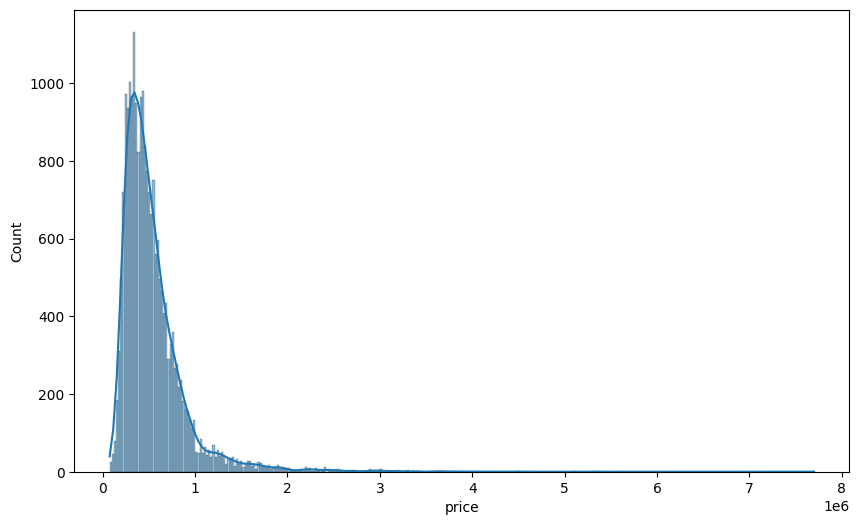

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', kde=True)

<Axes: xlabel='bedrooms', ylabel='count'>

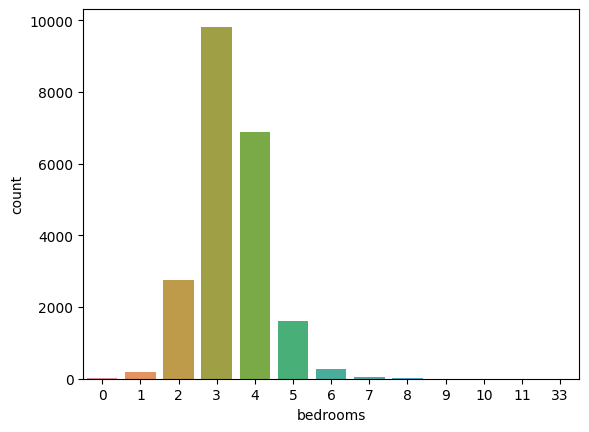

In [6]:
sns.countplot(data=df, x='bedrooms')

<Axes: >

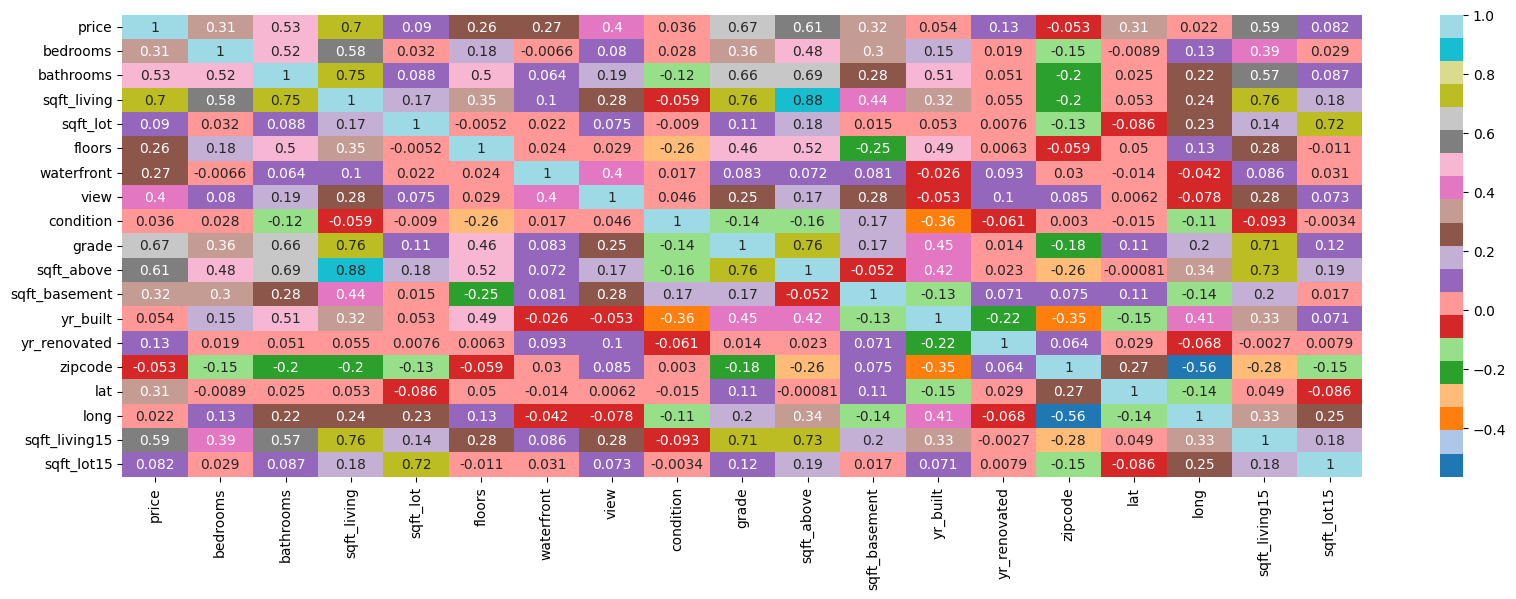

In [7]:
plt.figure(figsize=(20, 6))
corr = df.drop('date', axis=1).corr()
sns.heatmap(corr, cmap="tab20", annot=True)

In [8]:
df.drop('date', axis=1).corr()['price'].sort_values()

zipcode         -0.053203
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='sqft_living'>

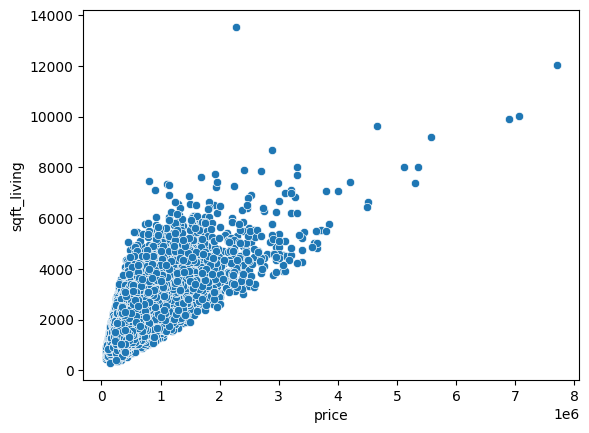

In [9]:
sns.scatterplot(x='price', y='sqft_living', data=df)

<Axes: xlabel='price', ylabel='sqft_above'>

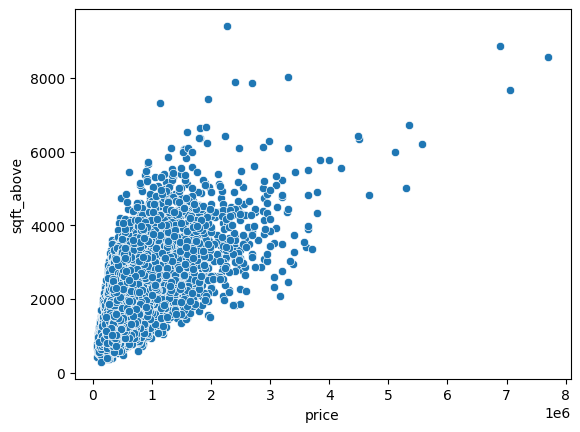

In [10]:
sns.scatterplot(x='price', y='sqft_above', data=df)

In [11]:
df['bathrooms']

0        1.00
1        2.25
2        1.00
3        3.00
4        2.00
         ... 
21608    2.50
21609    2.50
21610    0.75
21611    2.50
21612    0.75
Name: bathrooms, Length: 21613, dtype: float64

In [12]:
df['bathrooms'].value_counts()

bathrooms
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64

<Axes: xlabel='long', ylabel='lat'>

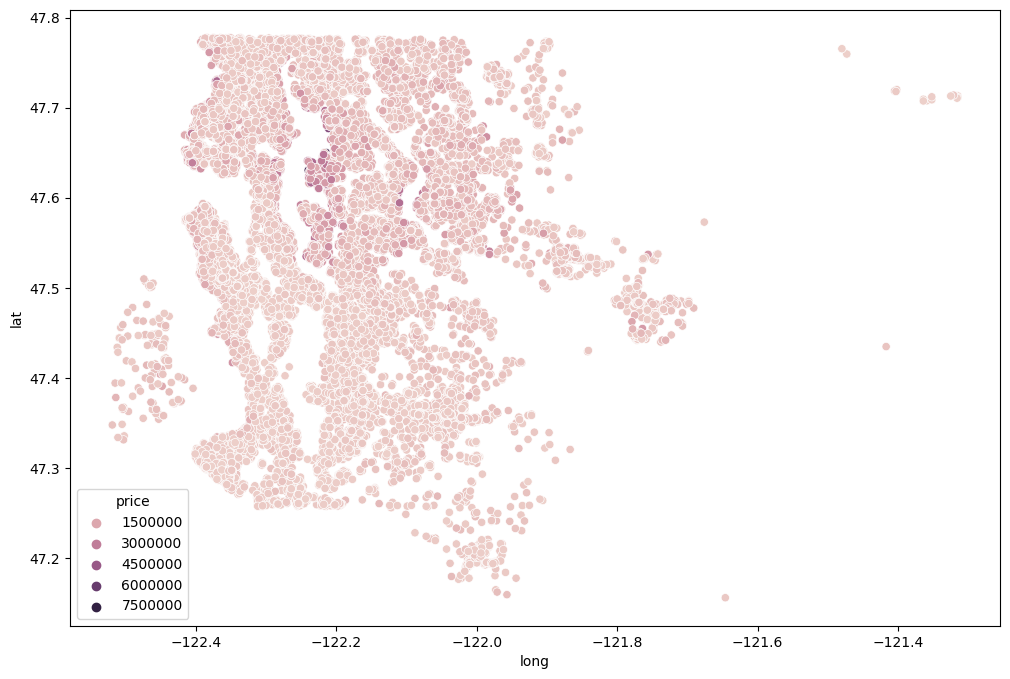

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', data=df, hue='price')

In [14]:
df['date']

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

## Feature engineering

In [15]:
def change_grade_to_categorical(x):
    if 1 <= x <= 3:
        return 1
    elif 3 < x < 7:
        return 2
    elif 7 <= x < 11:
        return 3
    else:
        return 4
    
    
df['grade'] = df['grade'].apply(change_grade_to_categorical)

In [16]:
df['bathrooms'] = df['bathrooms'].apply(ceil)

In [17]:
df['date'] = df['date'].apply(pd.to_datetime)

In [18]:
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)

In [19]:
df.drop('date', axis=1, inplace=True)

In [20]:
df.drop('zipcode', axis=1, inplace=True)

In [21]:
def change_yr_renovated(x):
    if x == 0:
        return 0
    return 1

In [22]:
df['is_renovated'] = df['yr_renovated'].apply(change_yr_renovated)

In [23]:
df.drop('yr_renovated', axis=1, inplace=True)

In [24]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,year,month,is_renovated
0,221900.0,3,1,1180,5650,1.0,0,0,3,3,1180.0,0,1955,47.5112,-122.257,1340,5650,2014,10,0
1,538000.0,3,3,2570,7242,2.0,0,0,3,3,2170.0,400,1951,47.7210,-122.319,1690,7639,2014,12,1
2,180000.0,2,1,770,10000,1.0,0,0,3,2,770.0,0,1933,47.7379,-122.233,2720,8062,2015,2,0
3,604000.0,4,3,1960,5000,1.0,0,0,5,3,1050.0,910,1965,47.5208,-122.393,1360,5000,2014,12,0
4,510000.0,3,2,1680,8080,1.0,0,0,3,3,1680.0,0,1987,47.6168,-122.045,1800,7503,2015,2,0


## Modelling Phase

In [25]:
df.dropna(axis=1, inplace=True)

X = df.drop('price', axis=1).values
y = df.price.values

In [26]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [27]:
# for some models, we'll use scaled values, for some, we're not


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 1000)
    }
    model = HistGradientBoostingRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

In [29]:
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-11-13 14:44:53,744] A new study created in memory with name: regression
[I 2023-11-13 14:44:53,991] Trial 0 finished with value: 0.815123174066157 and parameters: {'max_depth': 2, 'learning_rate': 0.2785042949286768, 'random_state': 953, 'max_leaf_nodes': 46}. Best is trial 0 with value: 0.815123174066157.
[I 2023-11-13 14:44:54,456] Trial 1 finished with value: 0.837670119808113 and parameters: {'max_depth': 8, 'learning_rate': 0.6499905182221252, 'random_state': 12, 'max_leaf_nodes': 579}. Best is trial 1 with value: 0.837670119808113.
[I 2023-11-13 14:44:54,944] Trial 2 finished with value: 0.8512945784357946 and parameters: {'max_depth': 5, 'learning_rate': 0.06764320932285066, 'random_state': 795, 'max_leaf_nodes': 718}. Best is trial 2 with value: 0.8512945784357946.
[I 2023-11-13 14:44:56,324] Trial 3 finished with value: 0.861306062034835 and parameters: {'max_depth': 9, 'learning_rate': 0.09244225721060445, 'random_state': 885, 'max_leaf_nodes': 875}. Best is trial 3 w

In [30]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 5, 'learning_rate': 0.20666366203019793, 'random_state': 697, 'max_leaf_nodes': 620}


In [31]:
# Print the best value
print('Best value', study.best_value)

Best value 0.8728838734299043


In [32]:
# Print the best trial
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=84, state=TrialState.COMPLETE, values=[0.8728838734299043], datetime_start=datetime.datetime(2023, 11, 13, 14, 45, 39, 268745), datetime_complete=datetime.datetime(2023, 11, 13, 14, 45, 39, 794004), params={'max_depth': 5, 'learning_rate': 0.20666366203019793, 'random_state': 697, 'max_leaf_nodes': 620}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'random_state': IntDistribution(high=1000, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=1000, log=False, low=2, step=1)}, trial_id=84, value=None)


In [33]:
model = Sequential()

model.add(Dense(19, activation='relu'))
model.add(Dense(19, activation='relu'))
model.add(Dense(19, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

model.fit(x=X_train_scaled, y=y_train, validation_data=(X_test_scaled, y_test), batch_size=128, epochs=350)

Epoch 1/350
119/119 [==============================] - 2s 4ms/step - loss: 422869860352.0000 - val_loss: 434782568448.0000
Epoch 2/350
119/119 [==============================] - 0s 2ms/step - loss: 421902352384.0000 - val_loss: 431175106560.0000
Epoch 3/350
119/119 [==============================] - 0s 3ms/step - loss: 404943405056.0000 - val_loss: 387439853568.0000
Epoch 4/350
119/119 [==============================] - 0s 3ms/step - loss: 303920447488.0000 - val_loss: 216298831872.0000
Epoch 5/350
119/119 [==============================] - 0s 3ms/step - loss: 136376090624.0000 - val_loss: 110017986560.0000
Epoch 6/350
119/119 [==============================] - 0s 3ms/step - loss: 102502211584.0000 - val_loss: 107678711808.0000
Epoch 7/350
119/119 [==============================] - 0s 3ms/step - loss: 100729577472.0000 - val_loss: 106049060864.0000
Epoch 8/350
119/119 [==============================] - 0s 3ms/step - loss: 99008593920.0000 - val_loss: 104294785024.0000
Epoch 9/350
119/1

In [34]:
losses = pd.DataFrame(model.history.history)

<Axes: >

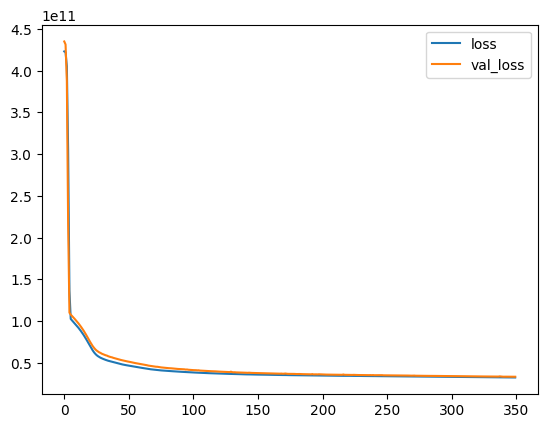

In [35]:
losses.plot()

In [36]:
regressor = HistGradientBoostingRegressor(**study.best_params)
kf = KFold(n_splits=10, shuffle=True, random_state=31)

reg = cross_validate(
    regressor,
    X_train,
    y_train,
    scoring='r2',
    return_train_score=True,
    cv=kf)

reg['test_score']

array([0.88525136, 0.87104059, 0.88374015, 0.88989749, 0.88786743,
       0.85286257, 0.85569247, 0.87952589, 0.89090248, 0.88150823])

In [37]:
regressor = HistGradientBoostingRegressor(**study.best_params)
rkf = RepeatedKFold(n_splits=10, random_state=31)

reg = cross_validate(
    regressor,
    X_train,
    y_train,
    scoring='r2',
    return_train_score=True,
    cv=rkf)

reg['test_score']

array([0.88525136, 0.87104059, 0.88374015, 0.88989749, 0.88786743,
       0.85286257, 0.85569247, 0.87952589, 0.89090248, 0.88150823,
       0.88195091, 0.83877633, 0.87311939, 0.88873068, 0.87129279,
       0.88825256, 0.86796192, 0.90539932, 0.88556045, 0.86108908,
       0.8841553 , 0.8866195 , 0.87726616, 0.88513835, 0.86918422,
       0.88959564, 0.86155984, 0.87006423, 0.8671076 , 0.86540328,
       0.86370312, 0.88918971, 0.88740708, 0.87259041, 0.86229085,
       0.89905177, 0.83728781, 0.88745875, 0.8845503 , 0.85827456,
       0.88102892, 0.87921649, 0.82222304, 0.89769825, 0.89280433,
       0.87794184, 0.86425207, 0.89321012, 0.89343683, 0.85691497,
       0.87520327, 0.84515243, 0.90976744, 0.86702745, 0.87005702,
       0.88336207, 0.87025693, 0.85355259, 0.86757864, 0.87005692,
       0.85615241, 0.87436428, 0.899836  , 0.89104439, 0.88294423,
       0.88770052, 0.86063756, 0.88216341, 0.87975451, 0.87582854,
       0.89151527, 0.88686267, 0.8869728 , 0.89112211, 0.90510